In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
import xarray as xr

import qcodes as qc
from qcodes.dataset.data_set import DataSet, new_data_set
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
from qcodes.dataset.measurements import ParamSpec
from qcodes.dataset.sqlite_base import (connect, get_dependencies,
                                        get_dependents, get_layout, get_runs)

In [2]:
from plottr.data.datadict import DataDict
from plottr.data.qcodes import DataSetDict

# Tools and definitions

In [3]:
def centers2edges(arr):
    e = (arr[1:] + arr[:-1]) / 2.
    e = np.concatenate(([arr[0] - (e[0] - arr[0])], e))
    e = np.concatenate((e, [arr[-1] + (arr[-1] - e[-1])]))
    return e

def pcolorgrid(xaxis, yaxis):
    xedges = centers2edges(xaxis)
    yedges = centers2edges(yaxis)
    xx, yy = np.meshgrid(xedges, yedges)
    return xx, yy

def pcolormesh(ax, x, y, z, **kw):
    xx, yy = pcolorgrid(x, y)
    im = ax.pcolormesh(xx, yy, z, **kw)
    return im

# DataDict class

## Testing gridding of data

### Data generation methods

A few functions to generate dummy data. Execute before running the examples.

In [ ]:
def fake_data_ex1(nx, ny):
    """
    Data that's actually on a nice grid.
    """
    x = np.linspace(-3, 3, nx)
    y = np.linspace(0, 4*np.pi, ny)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    zz = np.cos(yy) * np.exp(-xx**2)
    
    data = DataDict(
        z = dict(axes=['x', 'y'], values=zz.reshape(-1), unit='a.u.'),
        x = dict(values=xx.reshape(-1), unit='a.u.'),
        y = dict(values=yy.reshape(-1), unit='a.u.'),
    )
    data.validate()
    return data

def fake_data_ex2(nx, ny, nmissing=1):
    """
    Data that's on an incomplete grid (points missing at the end).
    """
    x = np.linspace(-3, 3, nx)
    y = np.linspace(0, 4*np.pi, ny)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    zz = np.cos(yy) * np.exp(-xx**2)
    
    data = DataDict(
        z = dict(axes=['x', 'y'], values=zz.reshape(-1)[:-nmissing], unit='a.u.'),
        x = dict(values=xx.reshape(-1)[:-nmissing], unit='a.u.'),
        y = dict(values=yy.reshape(-1)[:-nmissing], unit='a.u.'),
    )
    data.validate()
    return data

def fake_data_ex2b(nx, ny, missing_radius=3):
    """
    Data that's on an incomplete grid (stuff missing in the middle).
    we omit data where sqrt(x**2+(y-2pi)**2)**.5 < missing_radius.
    """
    
    _x = np.linspace(-3, 3, nx)
    _y = np.linspace(0, 4*np.pi, ny)
    x = []; y = []; z = []
    for i, xval in enumerate(_x):
        for j, yval in enumerate(_y):
            if (xval**2+(yval-np.pi*2)**2)**.5 < missing_radius:
                continue
            else:
                x.append(xval)
                y.append(yval)
                z.append(np.cos(yval) * np.exp(-xval**2))
    
    data = DataDict(
        z = dict(axes=['x', 'y'], values=np.array(z).reshape(-1), unit='a.u.'),
        x = dict(values=np.array(x).reshape(-1), unit='a.u.'),
        y = dict(values=np.array(y).reshape(-1), unit='a.u.'),
    )
    data.validate()
    return data

def fake_data_ex3(n):
    """
    Data that's not a good grid (x and y modified only in pairs).
    """
    x = np.linspace(-3, 3, n)
    y = np.linspace(0, 4*np.pi, n)
    z = np.cos(y) * np.exp(-x**2)
    
    data = DataDict(
        z = dict(axes=['x', 'y'], values=z.reshape(-1), unit='a.u.'),
        x = dict(values=x.reshape(-1), unit='a.u.'),
        y = dict(values=y.reshape(-1), unit='a.u.'),
    )
    data.validate()
    return data

def fake_data_ex4(n):
    """
    Data that's not on a grid at all.
    """
    x = np.random.rand(n) * 6 - 3
    y = np.random.rand(n) * 10.
    z = np.cos(y) * np.exp(-x**2)
    
    data = DataDict(
        z = dict(axes=['x', 'y'], values=z.reshape(-1), unit='a.u.'),
        x = dict(values=x.reshape(-1), unit='a.u.'),
        y = dict(values=y.reshape(-1), unit='a.u.'),
    )
    data.validate()
    return data

### A complete grid

In [ ]:
data = fake_data_ex1(41, 31)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

### An incomplete grid

This is basically emulating the case where the measurement has been aborted before finishing.

Note: The grid still gets reconstructed just fine, with the missing data points now being filled with NaN and masked (default behavior of get_grid()).

In [ ]:
data = fake_data_ex2(41, 31, 300)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

fig, ax = plt.subplots(1,1)
ax.plot(ret['y'], ret['z'].mean(axis=0), 'o')
ax.set_xlabel(data.label('y'))
ax.set_ylabel(data.label('z') + ' (x-average)')

### Missing a chunk in the middle

We can also look at the case where some data in the middle isn't there (maybe the measurement failed, or we didn't want to measure in that area for some reason). Again, gridding is very easy here, just some masked values.

In [ ]:
data = fake_data_ex2b(41, 31, 2)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

fig, ax = plt.subplots(1,1)
ax.plot(ret['y'], ret['z'].mean(axis=0), 'o')
ax.set_xlabel(data.label('y'))
ax.set_ylabel(data.label('z') + ' (x-average)')

### A bad grid

We sweep two things that could have been described better by a single parameter. But still the grid can be reconstructed, even though most of the data is empty now.

In [ ]:
data = fake_data_ex3(31)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

fig, ax = plt.subplots(1,1)
ax.plot(ret['y'], ret['z'].sum(axis=0), 'o')
ax.set_xlabel(data.label('y'))
ax.set_ylabel(data.label('z') + ' (x-sum)')

### No grid

We look at randomly sampled data now. This can of course still be put onto a grid, but it's not a good idea (and computationally expensive!). Looking at it in a scatter plot is much more instructive here.

In [ ]:
data = fake_data_ex4(1001)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

fig, ax = plt.subplots(1,1)
ax.plot(ret['y'], ret['z'].sum(axis=0), 'o')
ax.set_xlabel(data.label('y'))
ax.set_ylabel(data.label('z') + ' (x-sum)')

fig, ax = plt.subplots(1,1)
im = ax.scatter(data['x']['values'], data['y']['values'], 
                c=data['z']['values'])
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

## DataDict with Qcodes dataset2

### Saving test data

In [4]:
def prepare_data(**kw):
    names = kw.keys()
    vals = [v.reshape(-1) for v in kw.values()]
    ret = []
    for _vals in zip(*vals):
        ret.append(dict([(n, v) for n, v in zip(names, _vals)]))
    return ret

def ds_ex1(nx, ny):
    xvals = np.linspace(-3, 3, nx)
    yvals = np.linspace(0, 4*np.pi, ny)
    xx, yy = np.meshgrid(xvals, yvals, indexing='ij')
    zz = np.cos(yy) * np.exp(-xx**2)
    
    ds = new_data_set('test')
    ds.add_parameter(ParamSpec('x', 'numeric', unit='a.u.'))
    ds.add_parameter(ParamSpec('y', 'numeric', unit='a.u.'))
    ds.add_parameter(ParamSpec('z', 'numeric', unit='a.u.', depends_on=['x', 'y']))
    ds.add_results(prepare_data(x=xx, y=yy, z=zz))
    
    return ds

In [5]:
qc.config['core']['db_location'] = 'experiments.db'
exp = new_experiment('test', 'None')

ds = ds_ex1(41,51)
run_id = ds.run_id

<IPython.core.display.Javascript object>


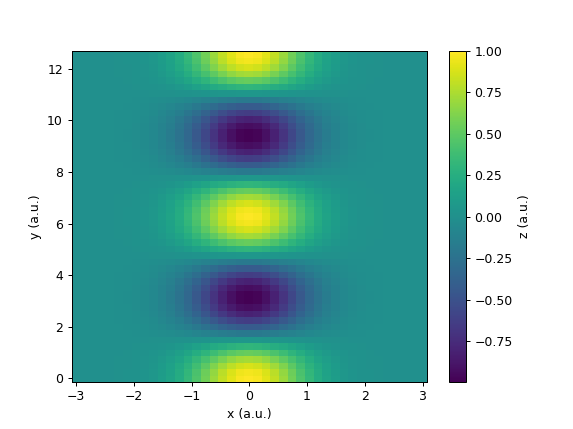

In [6]:
data = DataSetDict(run_id=run_id)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))